ID: 227542020

In [142]:
import pandas as pd
import numpy as np
import re
from functools import reduce
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

from scipy.stats import norm , zscore


import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

sns.set(rc={'figure.figsize':(9.7,5.27)})

# pd.set_option('display.float_format', lambda x: '%.0f' % x)
# pd.set_option('display.max_columns', 500)

import gspread
from oauth2client.service_account import ServiceAccountCredentials
from df2gspread import df2gspread as d2g

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"





In [16]:
def upload_to_gsheets(df, sheet_name):
    try:
        scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
        credentials = ServiceAccountCredentials.from_json_keyfile_name('data/key.json', scope)
        gc = gspread.authorize(credentials)

        spreadsheet_key = '1m9FORwuT65rdKjcVT1KtfA5kYZxxWcPgSurXmr6zlKk'
        wks_name = sheet_name
        d2g.upload(df, spreadsheet_key, wks_name, credentials=credentials, row_names=True)
        return 'Data Uploaded'
    except gspread.exceptions.APIError:
        sheet.insertRows(sheet.getLastRow(), data.length);

In [3]:
data = pd.read_excel('data/data_source.xlsx')

In [4]:
data.size
data.shape
data.dtypes

8100054

(150001, 54)

Bearer Id                                           object
Start                                       datetime64[ns]
Start ms                                           float64
End                                         datetime64[ns]
End ms                                             float64
IMSI                                               float64
MSISDN                                             float64
IMEI                                               float64
Last Location Name                                  object
Avg RTT DL (ms)                                    float64
Avg RTT UL (ms)                                    float64
Avg Bearer TP DL (kbps)                            float64
Avg Bearer TP UL (kbps)                            float64
TCP DL Retrans. Vol (Bytes)                        float64
TCP UL Retrans. Vol (Bytes)                        float64
DL TP < 50 Kbps (%)                                float64
50 Kbps < DL TP < 250 Kbps (%)                     float

In [ ]:
#Detect and exlude outliers from dataset


In [5]:
#data.isnull().sum()

#Drop rows with null values in unique columns
data = data.dropna(subset=['MSISDN', 'IMSI', 'IMEI'])

#replace null values with the mean in each column
data = data.fillna(data.mean())

#Convert these columns to string.
data[['Bearer Id','MSISDN','IMSI', 'IMEI', 'Last Location Name' ]] = data[['Bearer Id','MSISDN','IMSI', 'IMEI', 'Last Location Name' ]].astype(str)
data['Last Location Name'].fillna(data['Last Location Name'].mode()[0], inplace=True)


In [6]:
data.head()

,Bearer Id,Start,Start ms,End,End ms,IMSI,MSISDN,IMEI,Last Location Name,Avg RTT DL (ms),...,Youtube DL,Youtube UL,Netflix DL,Netflix UL,Gaming DL,Gaming UL,Other DL,Other UL,Total UL,Total DL
0,13114483460844900352,2019-04-04 12:01:18,770.0,2019-04-25 14:35:31,662.0,208201448079117.0,33664962239.0,35521209507511.0,9164566995485190,42.000000,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,13114483482878900224,2019-04-09 13:04:04,235.0,2019-04-25 08:15:48,606.0,208201909211140.0,33681854413.0,35794009006359.0,L77566A,65.000000,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,13114483484080500736,2019-04-09 17:42:11,1.0,2019-04-25 11:58:13,652.0,208200314458056.0,33760627129.0,35281510359387.0,D42335A,108.224741,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,13114483485442799616,2019-04-10 00:31:25,486.0,2019-04-25 07:36:35,171.0,208201402342131.0,33750343200.0,35356610164913.0,T21824A,108.224741,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,13114483499480700928,2019-04-12 20:10:23,565.0,2019-04-25 10:40:32,954.0,208201401415120.0,33699795932.0,35407009745539.0,D88865A,108.224741,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


### Overview Analysis


In [7]:
#Top 10 handsets used by customers
top10_handsets = data['Handset Type'].value_counts()[:10]
print(top10_handsets.to_markdown())



|                              |   Handset Type |
|:-----------------------------|---------------:|
| Huawei B528S-23A             |          19727 |
| Apple iPhone 6S (A1688)      |           9413 |
| Apple iPhone 6 (A1586)       |           9012 |
| undefined                    |           8931 |
| Apple iPhone 7 (A1778)       |           6304 |
| Apple iPhone Se (A1723)      |           5176 |
| Apple iPhone 8 (A1905)       |           4985 |
| Apple iPhone Xr (A2105)      |           4562 |
| Samsung Galaxy S8 (Sm-G950F) |           4480 |
| Apple iPhone X (A1901)       |           3810 |


In [56]:
top10_handsets

Huawei B528S-23A                19727
Apple iPhone 6S (A1688)          9413
Apple iPhone 6 (A1586)           9012
undefined                        8931
Apple iPhone 7 (A1778)           6304
Apple iPhone Se (A1723)          5176
Apple iPhone 8 (A1905)           4985
Apple iPhone Xr (A2105)          4562
Samsung Galaxy S8 (Sm-G950F)     4480
Apple iPhone X (A1901)           3810
Name: Handset Type, dtype: int64

Text(0.5, 1.0, 'Top 10 handsets used by customers')

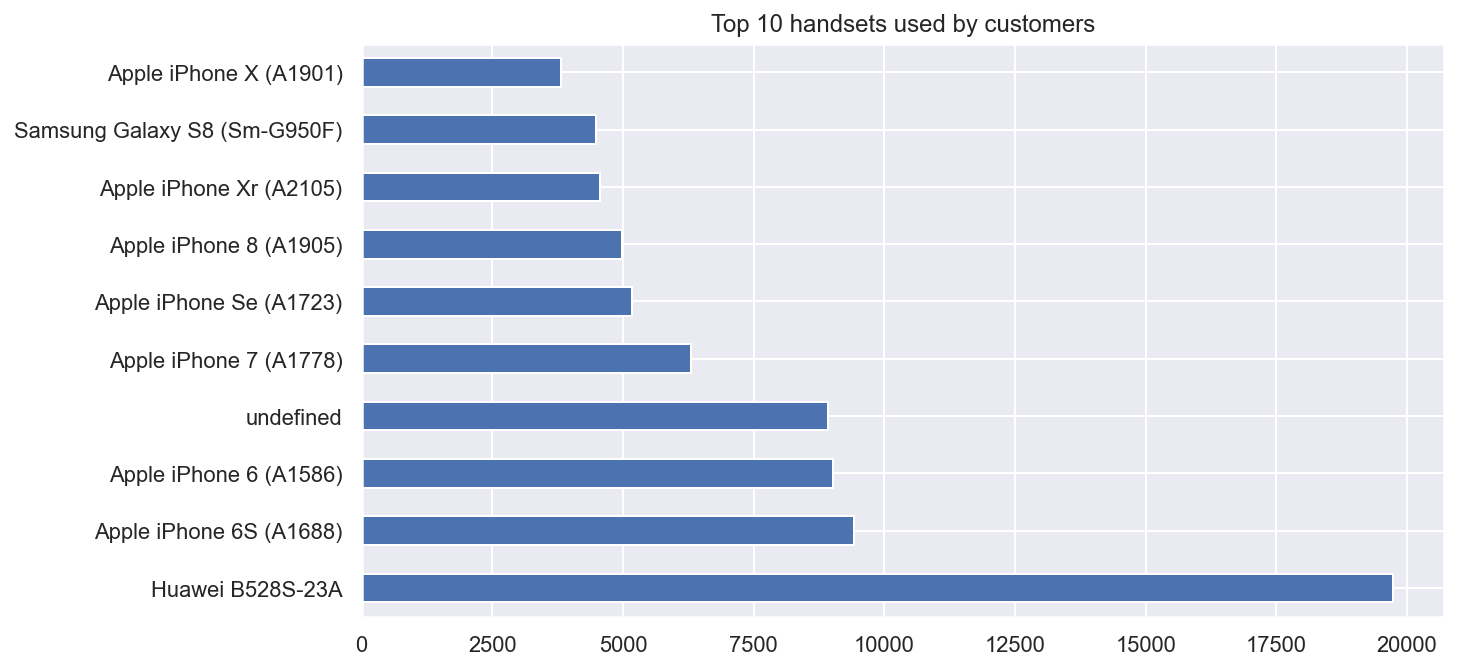

In [63]:
top10_handsets.plot(kind='barh').set_title('Top 10 handsets used by customers')


In [8]:
#Top 3 handset manufacturers
top3_mfr = data.groupby('Handset Manufacturer')['Handset Type'].count().sort_values(ascending=False)[:3]
print(top3_mfr.to_markdown())

| Handset Manufacturer   |   Handset Type |
|:-----------------------|---------------:|
| Apple                  |          59464 |
| Samsung                |          40579 |
| Huawei                 |          34366 |


Text(0.5, 1.0, 'Top 3 handset Manufacturers')

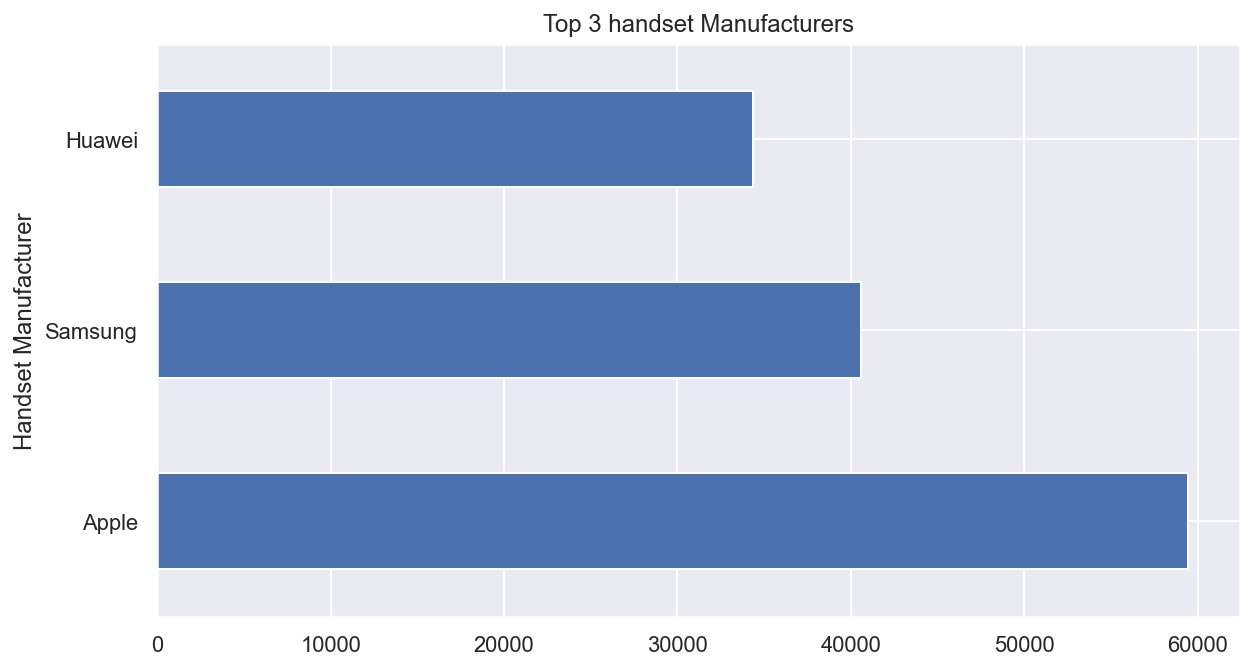

In [67]:
top3_mfr.plot(kind='barh').set_title('Top 3 handset Manufacturers')

In [323]:
#Top 5 handsets per manufacturer
mfrs = data.groupby(['Handset Manufacturer', 'Handset Type']).size().reset_index(name = 'count')
top5 = mfrs.sort_values(['Handset Manufacturer', 'count'], ascending = False).head(5)
top5

,Handset Manufacturer,Handset Type,count
1393,undefined,undefined,8931
1391,Zyxel Communications Corp,Zyxel Communicat. Lte7460,1
1392,Zyxel Communications Corp,Zyxel Communicat. Sbg3600,1
1390,ZyXEL Communications Corp,Zyxel Communicat. Zyxel Wah7706,1
1385,Zte,Zte Mf259,168


In [105]:
#Convert to MB. Multiply by (1e-6)
#Convert microseconds to minutes by multiplying by (1.66667e-8)

data['Dur'] = data['Dur'].mul(1.66667e-8)
data['total_bytes'] =  (data['Total UL'] + data['Total DL']).mul(1e-6)
data['social_media'] = (data['Social Media DL'] + data['Social Media UL']).mul(1e-6)
data['email'] = (data['Email DL'] + data['Email UL']).mul(1e-6)
data['google'] = (data['Google DL'] + data['Google UL']).mul(1e-6)
data['youtube'] = (data['Youtube DL'] + data['Youtube UL']).mul(1e-6)
data['netflix'] = (data['Netflix UL'] + data['Netflix DL']).mul(1e-6)
data['gaming'] = (data['Gaming DL'] + data['Gaming UL']).mul(1e-6)
data['other'] = (data['Other DL'] + data['Other UL']).mul(1e-6)

### Non-Graphical Univariate Analysis


In [106]:
#Information per user
user = data.groupby('MSISDN')


num_xdr = user.agg({'Bearer Id':'count'}).reset_index()
session_duration = user.agg({'Dur':'sum'}).reset_index() 
total_data = user.agg({'total_bytes':'sum'}).reset_index()
google_volume = user.agg({'google': 'sum'}).sum(axis=1).reset_index(name='google_data')
social_volume = user.agg({'social_media':'sum'}).sum(axis=1).reset_index(name='social_data')
email_volume = user.agg({'email':'sum'}).sum(axis=1).reset_index(name='email_data')
youtube_volume = user.agg({'youtube': 'sum'}).sum(axis=1).reset_index(name='youtube_data')
netflix_volume = user.agg({'netflix':'sum'}).sum(axis=1).reset_index(name='netflix_data')
gaming_volume = user.agg({'gaming':'sum'}).sum(axis=1).reset_index(name='gaming_data')

In [107]:
frames = [num_xdr, session_duration, total_data, google_volume, social_volume, email_volume, youtube_volume, netflix_volume, gaming_volume]
stats = pd.concat(frame for frame in frames).describe()
upload_to_gsheets(stats, 'summary stats')
stats

'Data Uploaded'

,Bearer Id,Dur,total_bytes,google_data,social_data,email_data,youtube_data,netflix_data,gaming_data
count,106856.000000,106856.000000,106856.000000,106856.000000,106856.000000,106856.000000,106856.000000,106856.000000,106856.000000
mean,1.393792,2.436137,690.962103,10.882434,2.547967,3.148796,31.558399,31.538332,599.769011
std,0.806022,3.105989,491.055891,7.544861,1.908038,2.222400,21.294918,21.289557,449.150462
min,1.000000,0.119050,33.249009,0.040330,0.001563,0.018176,0.078903,0.184569,0.306358
25%,1.000000,1.188475,358.549907,5.942636,1.211281,1.674481,18.631088,18.555973,288.063112
50%,1.000000,1.712340,617.923138,9.586153,2.303756,2.799824,26.800376,26.718889,542.349207
75%,2.000000,2.880006,857.435148,13.214740,3.307509,3.847198,37.927976,37.976957,777.304138
max,18.000000,309.230010,8846.226494,152.191852,43.374779,42.418782,452.958769,399.519079,7749.432234


### Graphical Univariate Analysis

Text(0.5, 0, 'Minutes')

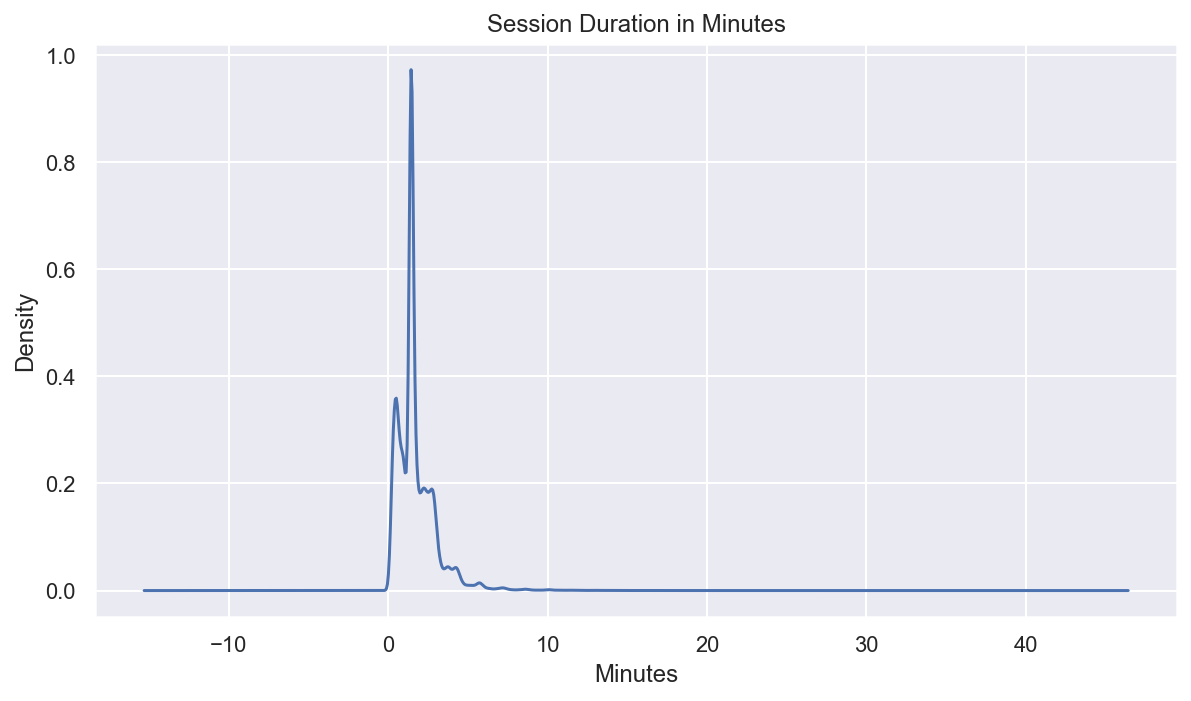

In [108]:
#Number of xDR sessions do not have variations in the data so there is no need to plot it.


data['Dur'].plot(kind='kde', title='Session Duration in Minutes')
plt.xlabel('Minutes')

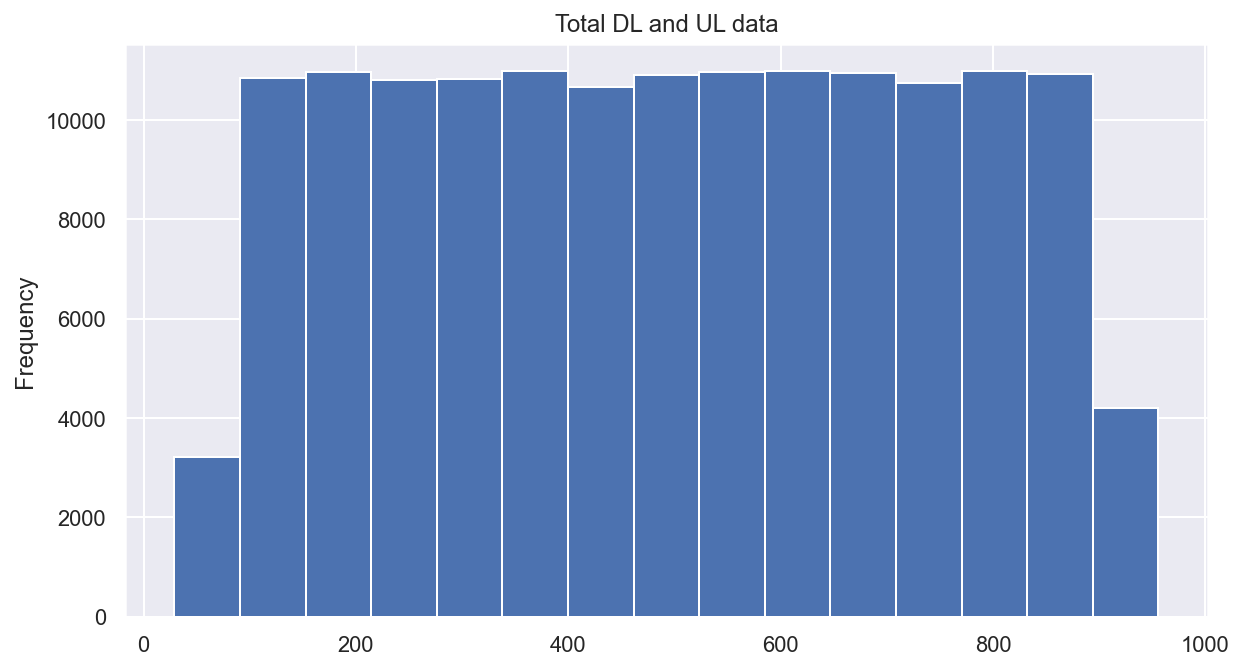

In [30]:
data['total_bytes'].plot(kind='hist', title='Total DL and UL data', bins=15)


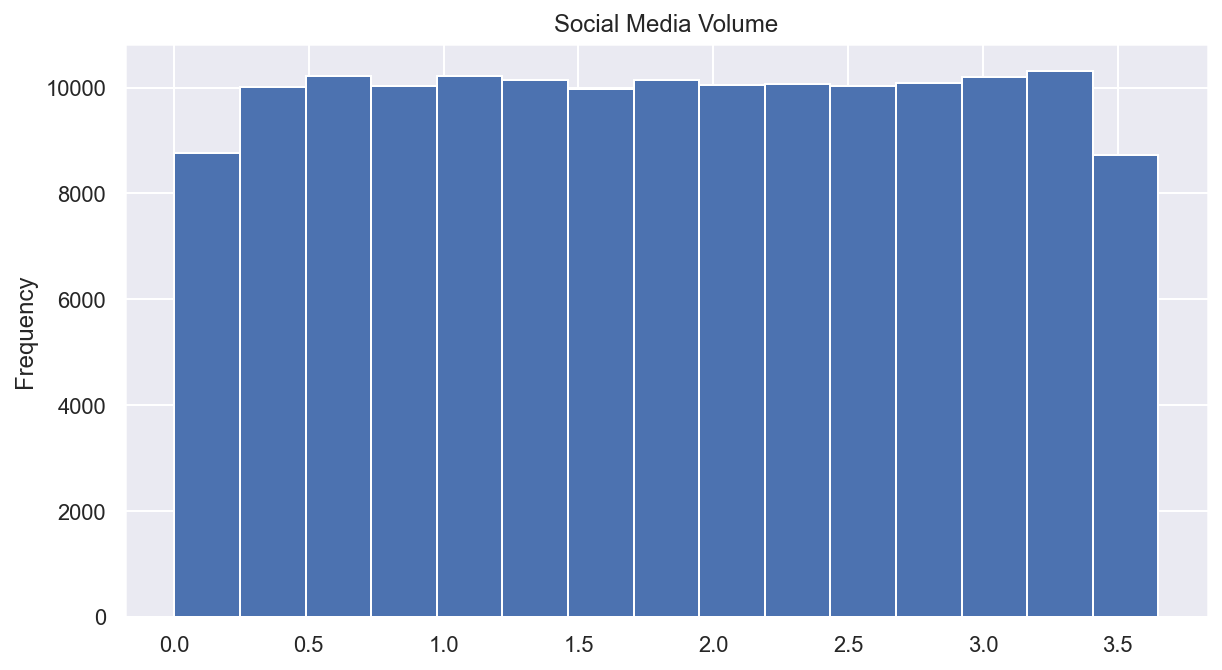

In [21]:
data['social_media'].plot(kind='hist', title='Social Media Volume', bins=15)


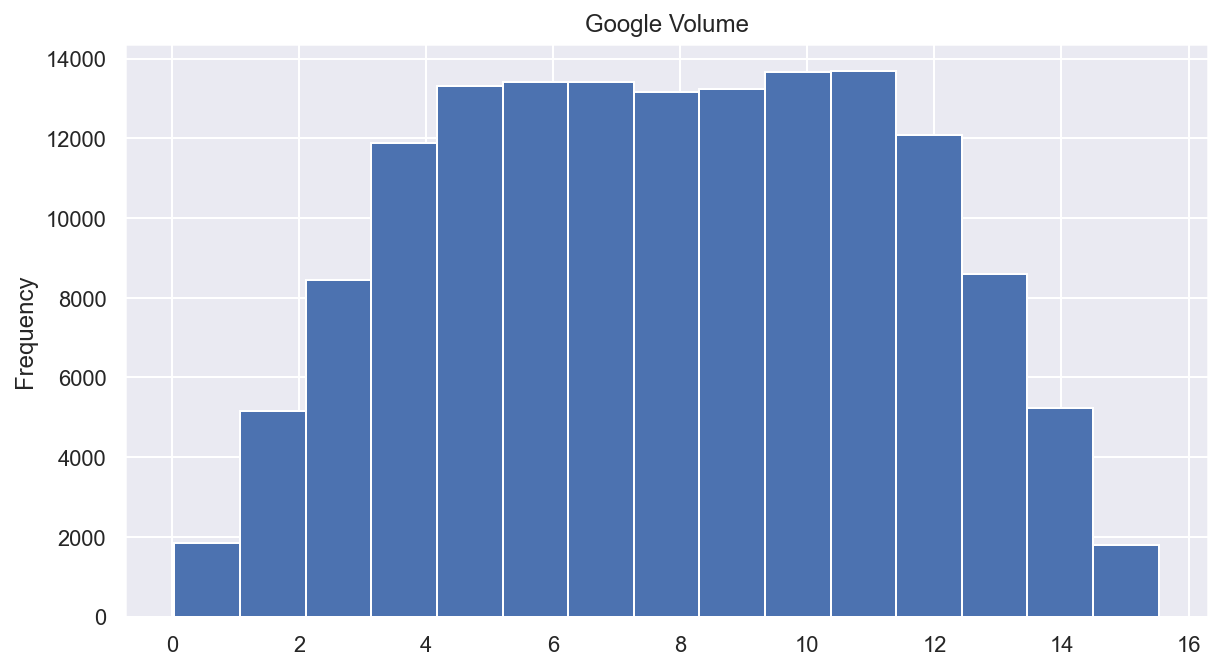

In [22]:
data['google'].plot(kind='hist', title='Google Volume', bins=15)

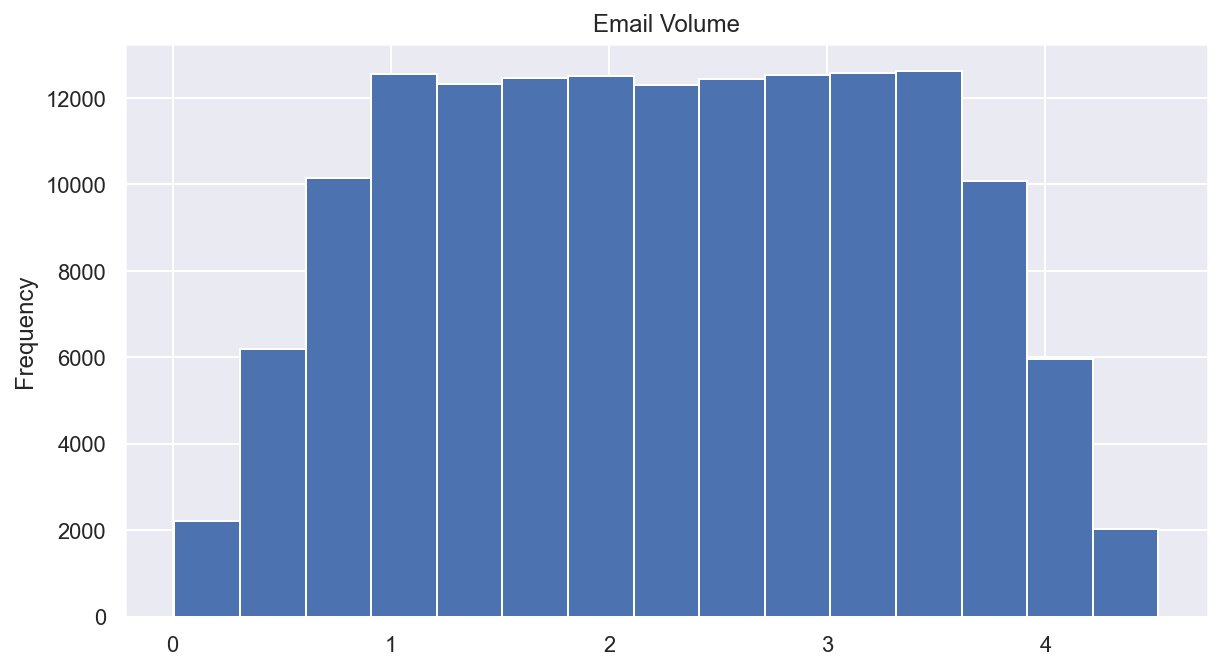

In [23]:
data['email'].plot(kind='hist', title='Email Volume', bins=15)


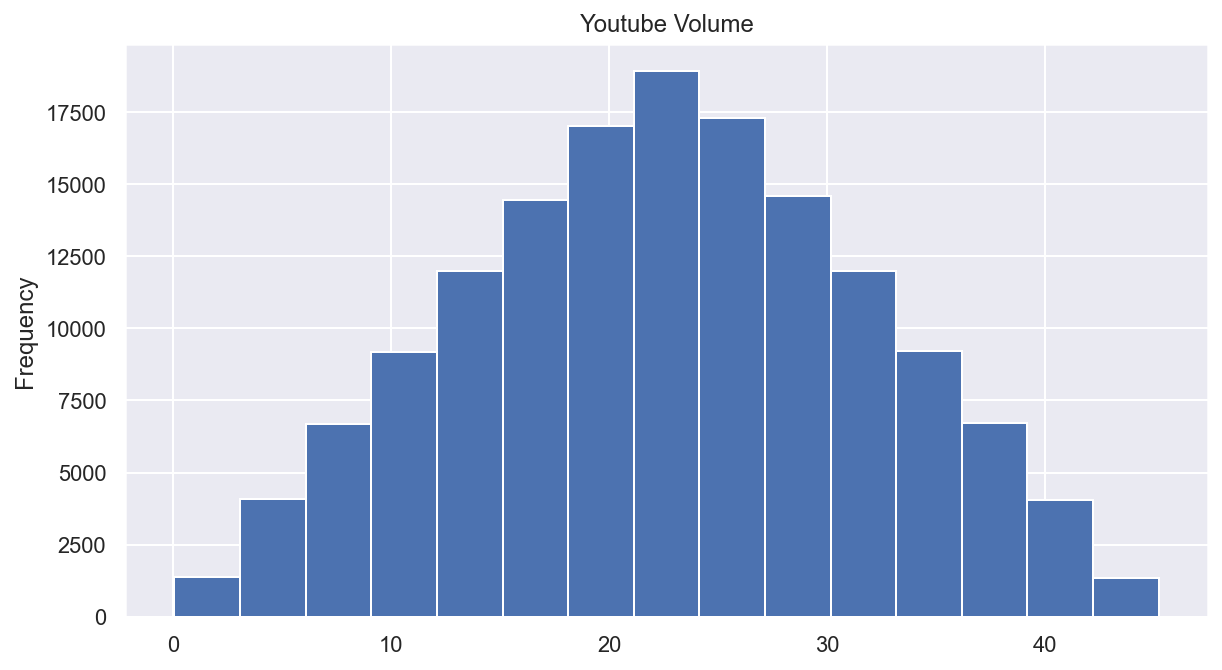

In [24]:
data['youtube'].plot(kind='hist', title='Youtube Volume', bins=15)


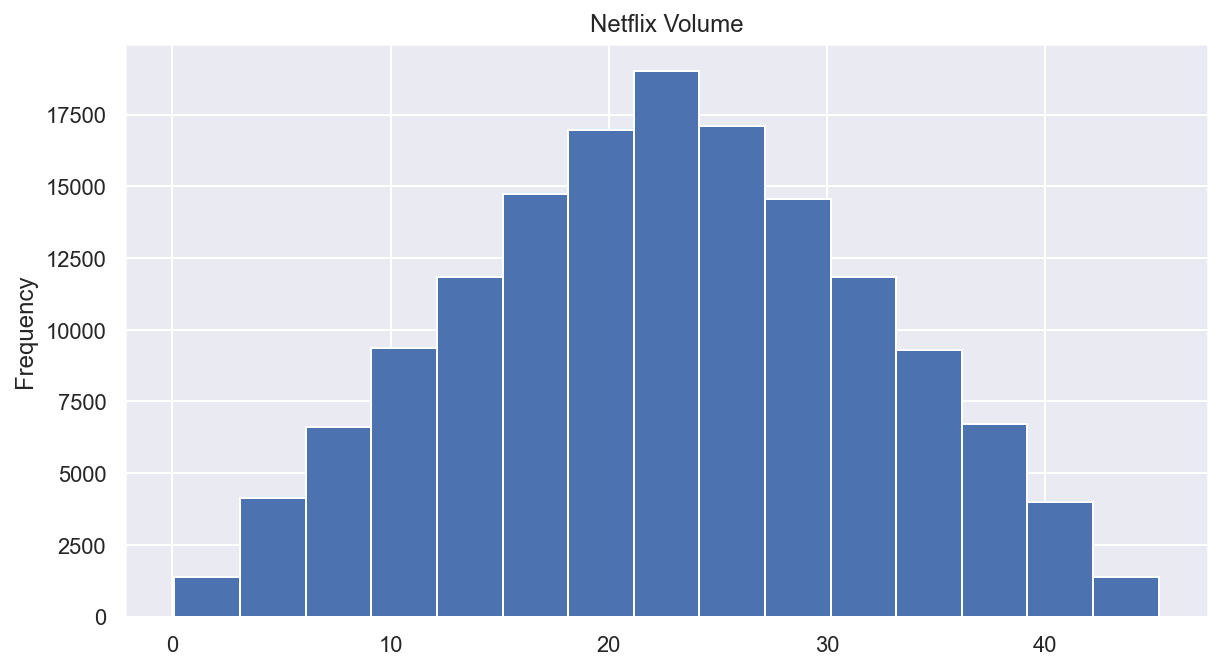

In [25]:
data['netflix'].plot(kind='hist', title='Netflix Volume', bins=15)


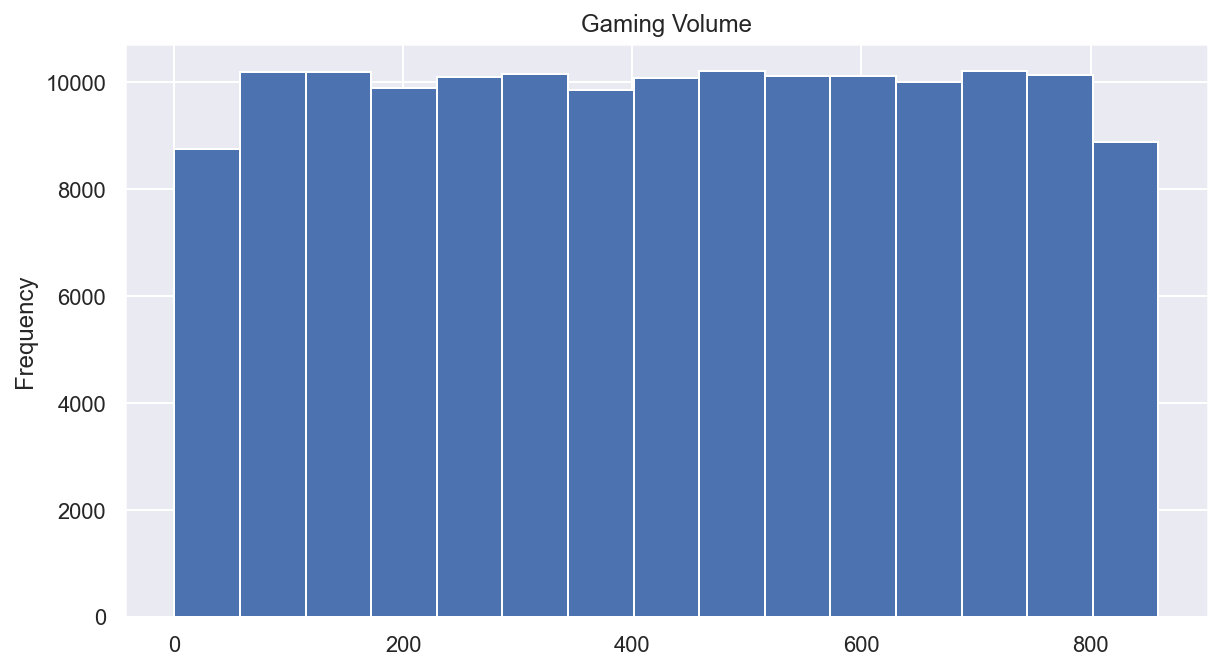

In [109]:
data['gaming'].plot(kind='hist', title='Gaming Volume', bins=15)

### Bivariate Analysis


In [44]:
social_apps = pd.DataFrame({'Application': ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming'],
                          'total_data':[data['social_media'].sum(), data['google'].sum(),
                                       data['email'].sum(), data['youtube'].sum(),
                                       data['netflix'].sum(),data['gaming'].sum()
                                       ]})
social_apps = social_apps.sort_values(by='total_data', ascending=False)


#bivariate = data[['social_media', 'google', 'email', 'youtube', 'netflix', 'gaming']]

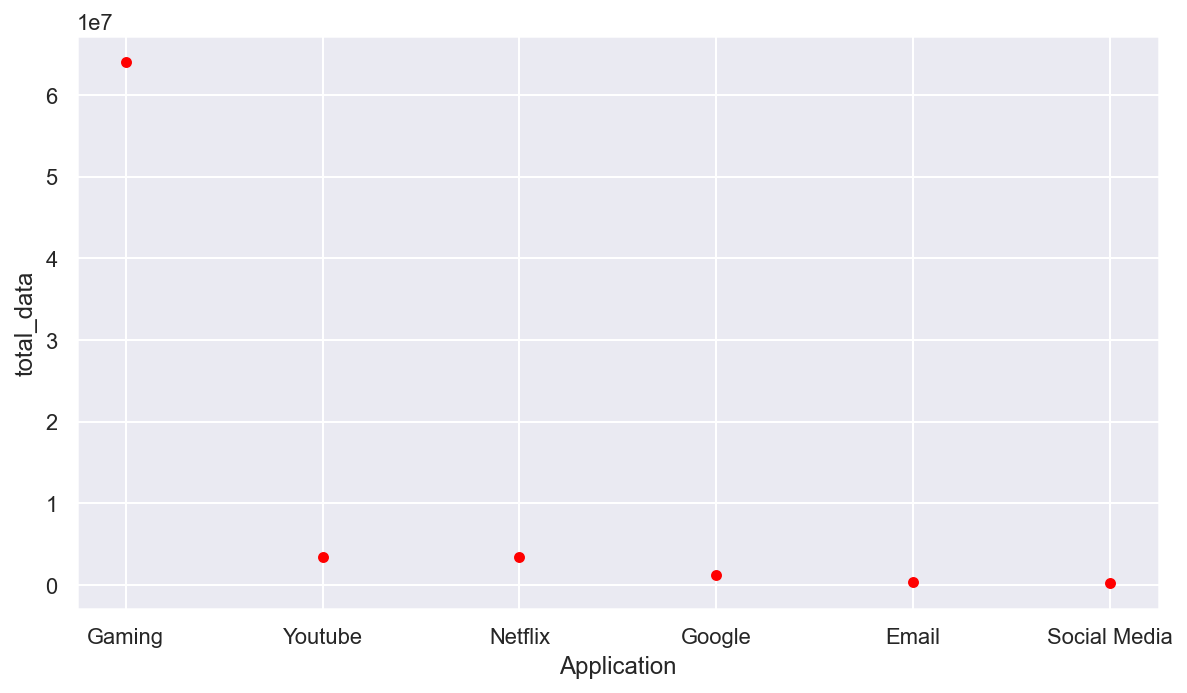

In [51]:
#sns.barplot(data=social_apps, x='Application', y='total_data').set_title('Social Apps Consumption')

social_apps.plot.scatter(x='Application', y='total_data', c='red')


### Variable Transformations

In [68]:
top5_deciles = 

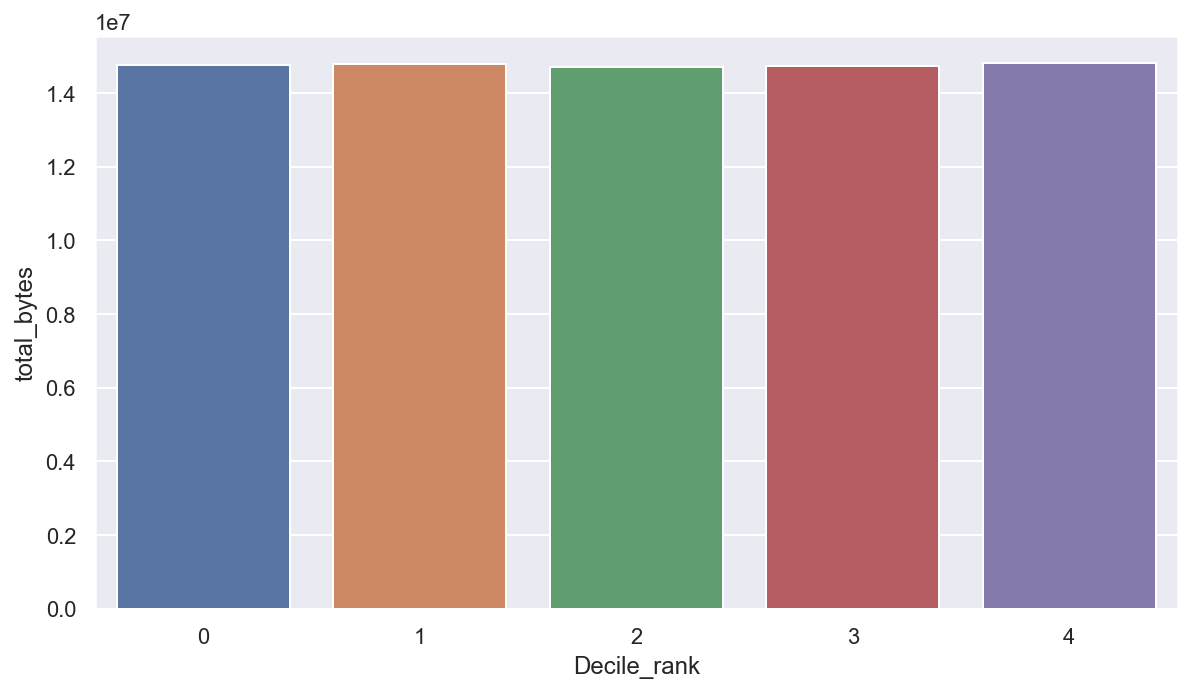

In [69]:
ranks = data[['Decile_rank', 'total_bytes']].groupby('Decile_rank').sum()
d = sns.barplot(x=ranks.index, y=ranks.total_bytes)


### Correlation Analysis


[Text(0.5, 0, 'social_media'),
 Text(1.5, 0, 'google'),
 Text(2.5, 0, 'email'),
 Text(3.5, 0, 'youtube'),
 Text(4.5, 0, 'netflix'),
 Text(5.5, 0, 'gaming'),
 Text(6.5, 0, 'other')]

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

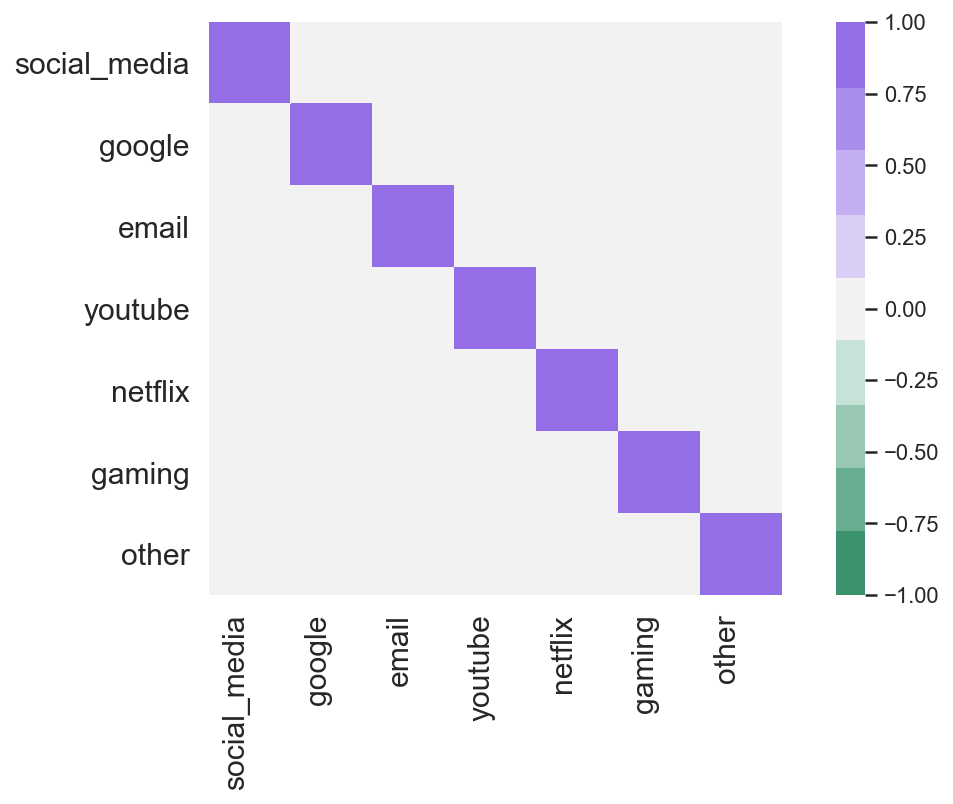

In [70]:
corr_data = data[['social_media', 'google', 'email', 'youtube', 'netflix', 'gaming', 'other']].corr(method='pearson')

ax = sns.heatmap(
    corr_data, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [71]:
corr_data

,social_media,google,email,youtube,netflix,gaming,other
social_media,1.000000,-0.001855,0.004122,0.000677,0.001421,0.001387,0.005849
google,-0.001855,1.000000,-0.000288,0.002542,-0.001911,-0.000949,-0.001904
email,0.004122,-0.000288,1.000000,-0.003233,0.001287,-0.000513,-0.001034
youtube,0.000677,0.002542,-0.003233,1.000000,0.003194,-0.003118,0.003198
netflix,0.001421,-0.001911,0.001287,0.003194,1.000000,-0.003092,-0.008791
gaming,0.001387,-0.000949,-0.000513,-0.003118,-0.003092,1.000000,-0.002789
other,0.005849,-0.001904,-0.001034,0.003198,-0.008791,-0.002789,1.000000


### Dimensionality Reduction

In [74]:
#Select only numerical data 
numerical_data = data.select_dtypes(include='number')

In [75]:
#first scale the data
scaled_data = StandardScaler().fit_transform(numerical_data)

/Users/Virgo/anaconda3/envs/10academy/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Virgo/anaconda3/envs/10academy/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [85]:
pca = PCA(n_components=23)
pcamodel = pca.fit_transform(scaled_data)
pcamodel.shape
pcamodel.explained_variance_

(148935, 23)

AttributeError: 'numpy.ndarray' object has no attribute 'explained_variance_'

## User Engagement Analysis


In [111]:
#Group by session frequency
session_freq = user['Bearer Id'].count().reset_index(name='session_frequency').sort_values('session_frequency', ascending = False)
session_freq

,MSISDN,session_frequency
13527,33626320676.0,18
6438,33614892860.0,17
13181,33625779332.0,17
37053,33659725664.0,16
92925,33760536639.0,15
...,...,...
41060,33660675684.0,1
41059,33660674747.0,1
41058,33660674252.0,1
41056,33660673991.0,1


Text(0.5, 1.0, 'Top 10 Customers By Session Frequency')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

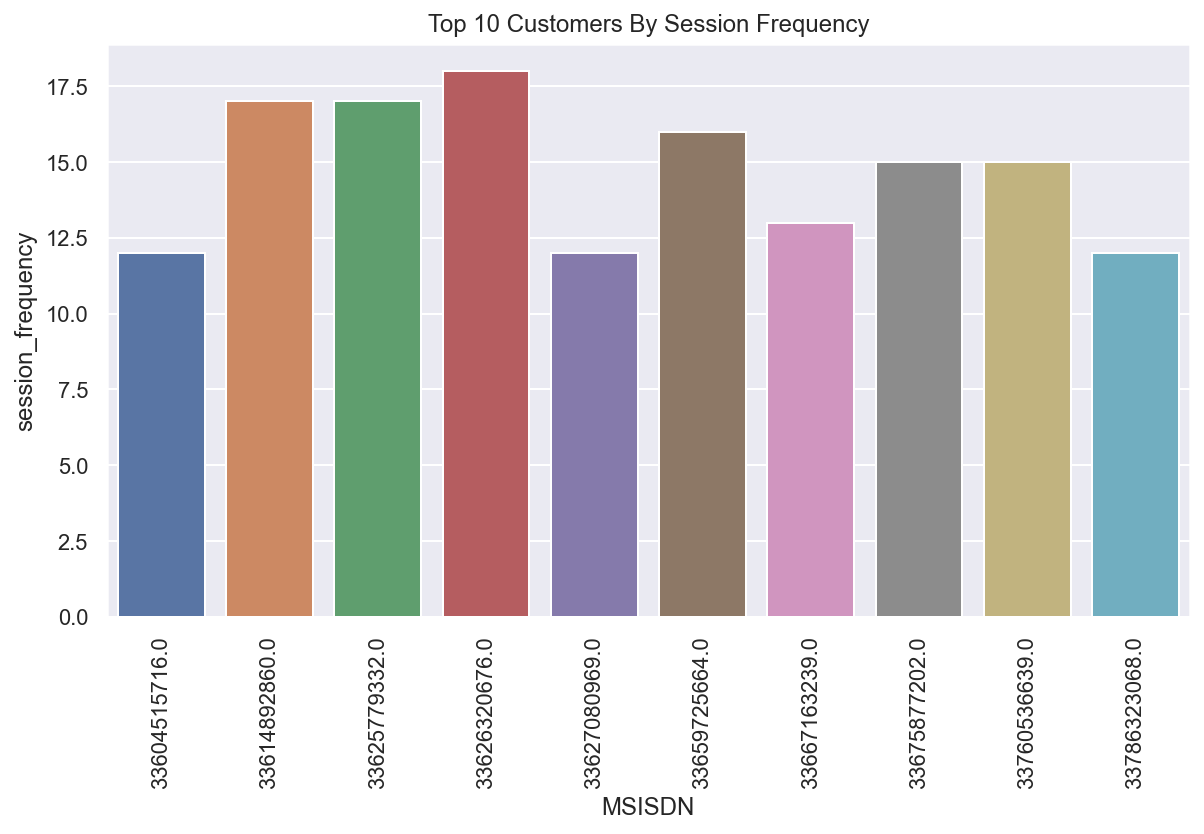

In [90]:
sns.barplot(data=session_freq[:10], x='MSISDN', y='session_frequency')
plt.title('Top 10 Customers By Session Frequency')
plt.xticks(rotation=90)

In [112]:
#Group by session duration
session_dur = user['Dur'].sum().reset_index(name='session_duration_mins').sort_values('session_duration_mins', ascending = False)
session_dur



,MSISDN,session_duration_mins
13181,33625779332.0,309.230010
6438,33614892860.0,166.115428
92925,33760536639.0,154.657676
13527,33626320676.0,146.532571
65119,33667163239.0,145.748992
...,...,...
24742,33650431620.0,0.121117
85147,33698390293.0,0.120968
35288,33659328207.0,0.119817
60768,33665660120.0,0.119110


Text(0.5, 1.0, 'Top 10 Customers By Session Duration')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

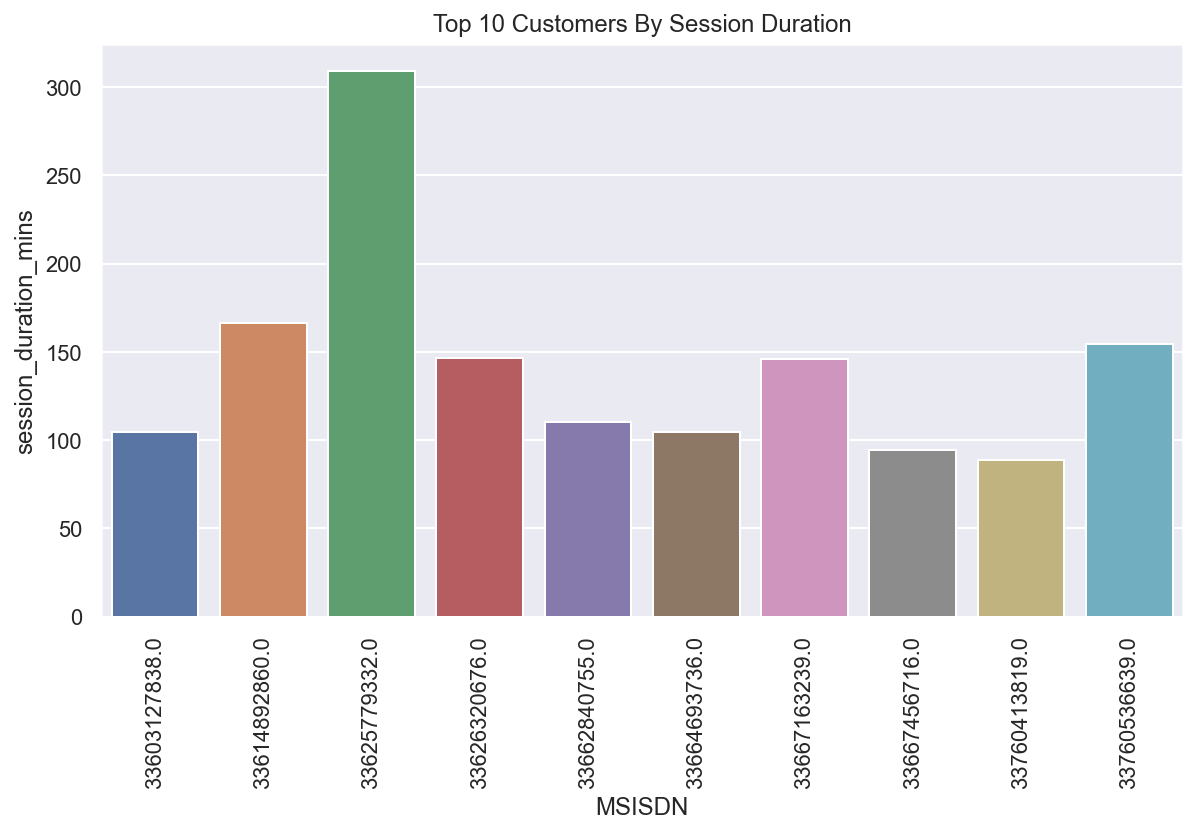

In [113]:
sns.barplot(data=session_dur[:10], x='MSISDN', y='session_duration_mins')
plt.title('Top 10 Customers By Session Duration')
plt.xticks(rotation=90)

In [114]:
#Group by sessions total traffic
session_traffic = user['total_bytes'].sum().reset_index(name='session_traffic_MB').sort_values('session_traffic_MB', ascending = False)
session_traffic

,MSISDN,session_traffic_MB
6438,33614892860.0,8846.226494
92925,33760536639.0,8514.773963
13181,33625779332.0,8499.620722
13527,33626320676.0,7971.167261
76364,33675877202.0,7891.110608
...,...,...
76162,33675475328.0,38.022357
104771,33782507973.0,37.929241
63658,33666684512.0,33.999624
43678,33661319633.0,33.575840


Text(0.5, 1.0, 'Top 10 Customers By Session Traffic')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

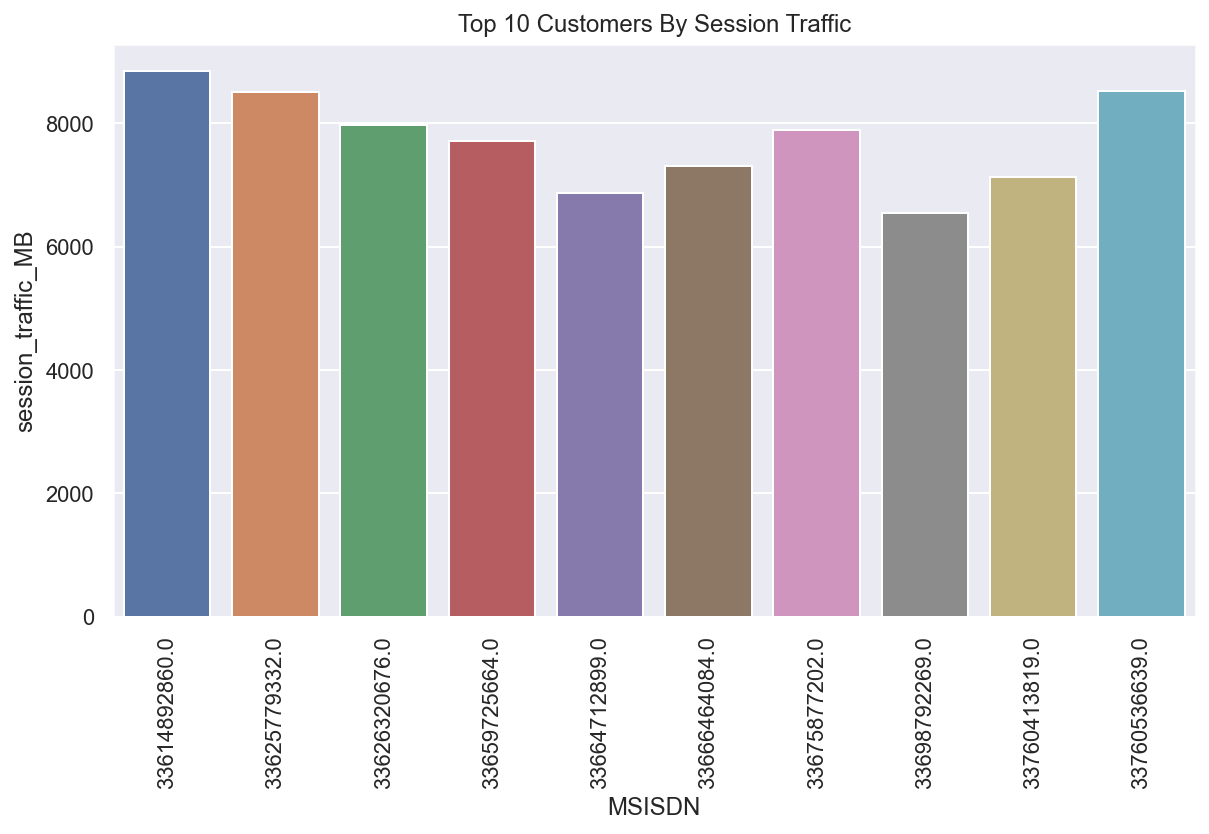

In [115]:
sns.barplot(data=session_traffic[:10], x='MSISDN', y='session_traffic_MB')
plt.title('Top 10 Customers By Session Traffic')
plt.xticks(rotation=90)

### Cluster

In [199]:
eng_metrics = pd.DataFrame({
    'MSISDN': session_freq.MSISDN,
    'session_frequency': session_freq.session_frequency,
    'session_duration_mins': session_dur.session_duration_mins,
    'session_traffic_MB':session_traffic.session_traffic_MB})

In [204]:
norm_metrics = MinMaxScaler().fit_transform(eng_metrics.drop('MSISDN', axis=1))
norm_metrics

/Users/Virgo/anaconda3/envs/10academy/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


array([[0.00000000e+00, 4.69218819e-02, 2.25661489e-02],
       [0.00000000e+00, 5.90820047e-03, 9.59314337e-02],
       [0.00000000e+00, 9.38650656e-03, 1.40259786e-02],
       ...,
       [0.00000000e+00, 8.99193468e-05, 7.73169605e-02],
       [0.00000000e+00, 7.21671482e-03, 5.07272743e-02],
       [0.00000000e+00, 4.65152782e-02, 1.20168964e-02]])

In [205]:
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)
results  = kmeans.fit(norm_metrics)
labels = kmeans.labels_
print(labels)
eng_metrics['Cluster'] = labels


[1 1 1 ... 1 1 1]


In [206]:
eng_groups = eng_metrics['Cluster'].value_counts()
eng_groups

1    81163
0    21632
2     4061
Name: Cluster, dtype: int64

### Compute stats

In [207]:
cluster_0_stats = eng_metrics[eng_metrics.Cluster == 0].describe()
cluster_0_stats

,session_frequency,session_duration_mins,session_traffic_MB,Cluster
count,21632.000000,21632.000000,21632.000000,21632.0
mean,2.176452,3.560313,1125.715227,0.0
std,0.405311,2.421740,295.945685,0.0
min,2.000000,0.303931,284.218230,0.0
25%,2.000000,1.932892,892.837282,0.0
50%,2.000000,3.026000,1099.802404,0.0
75%,2.000000,4.464498,1345.378442,0.0
max,4.000000,52.913849,1873.330284,0.0


In [208]:
cluster_1_stats = eng_metrics[eng_metrics.Cluster == 1].describe()
cluster_1_stats

,session_frequency,session_duration_mins,session_traffic_MB,Cluster
count,81163.000000,81163.000000,81163.000000,81163.0
mean,1.042285,1.783267,495.513129,1.0
std,0.201240,1.309587,240.142925,0.0
min,1.000000,0.119050,33.249009,1.0
25%,1.000000,0.929624,292.080308,1.0
50%,1.000000,1.440018,497.075268,1.0
75%,1.000000,2.368496,698.458698,1.0
max,2.000000,26.223736,950.760661,1.0


In [209]:
cluster_2_stats = eng_metrics[eng_metrics.Cluster == 2].describe()
cluster_2_stats

,session_frequency,session_duration_mins,session_traffic_MB,Cluster
count,4061.000000,4061.000000,4061.000000,4061.0
mean,4.249938,9.496146,2281.369767,2.0
std,1.233094,11.102339,652.873049,0.0
min,3.000000,0.781653,1085.993876,2.0
25%,4.000000,5.578341,1885.263309,2.0
50%,4.000000,7.046266,2136.442152,2.0
75%,5.000000,8.923552,2539.910970,2.0
max,18.000000,309.230010,8846.226494,2.0


### Top 10 most engaged users per application


Text(0.5, 1.0, 'Top 10 Most engaged Google users')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

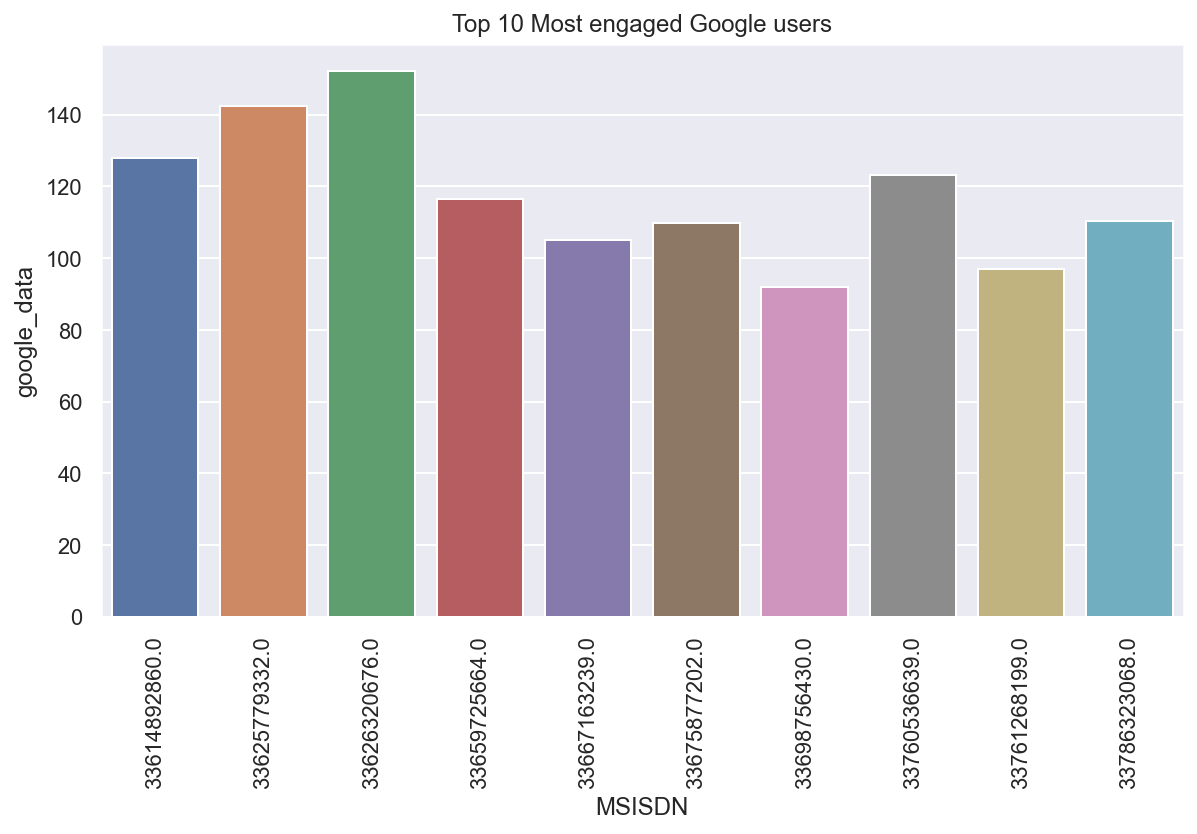

In [123]:
top10_google = google_volume.sort_values(by='google_data', ascending=False)[:10]
sns.barplot(data=top10_google, x='MSISDN', y='google_data')
plt.title('Top 10 Most engaged Google users')
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Top 10 Most engaged Social Media users')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

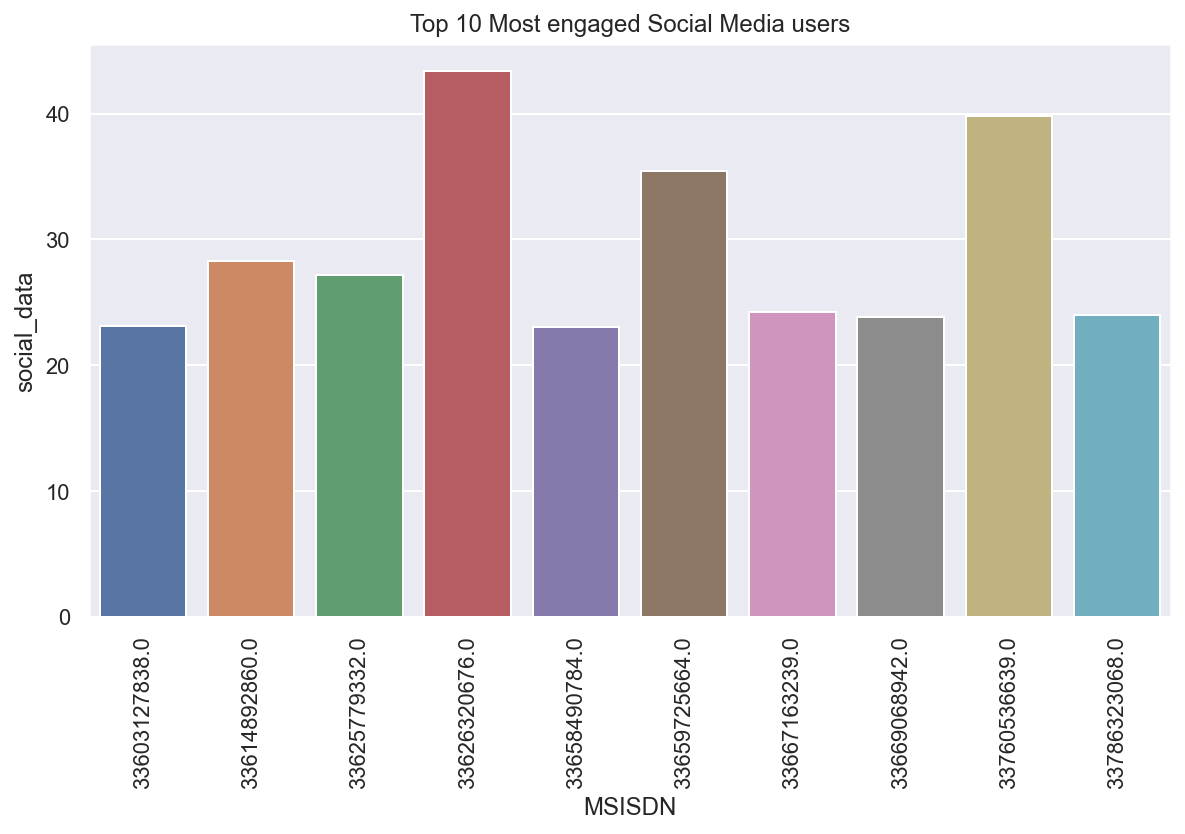

In [124]:
top10_social = social_volume.sort_values(by='social_data', ascending=False)[:10]
sns.barplot(data=top10_social, x='MSISDN', y='social_data')
plt.title('Top 10 Most engaged Social Media users')
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Top 10 Most engaged Email users')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

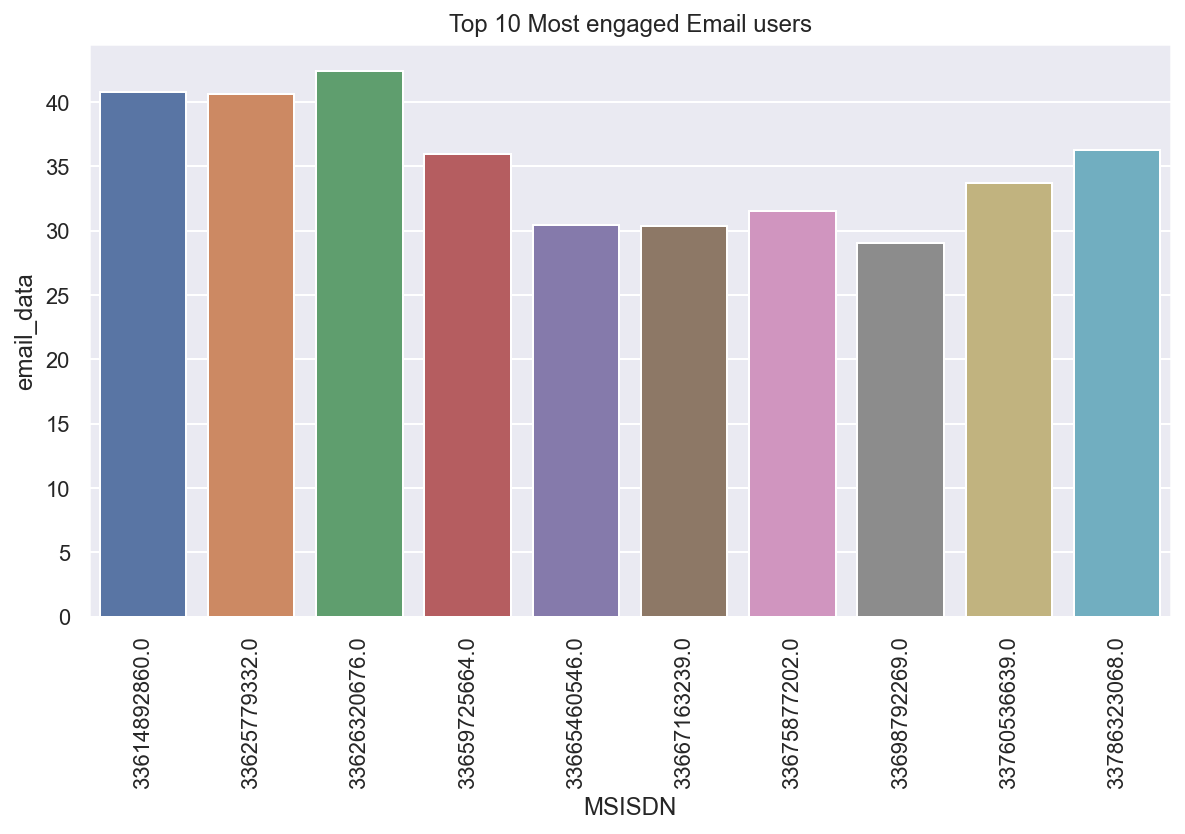

In [125]:
top10_email = email_volume.sort_values(by='email_data', ascending=False)[:10]
sns.barplot(data=top10_email, x='MSISDN', y='email_data')
plt.title('Top 10 Most engaged Email users')
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Top 10 Most engaged Youtube users')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

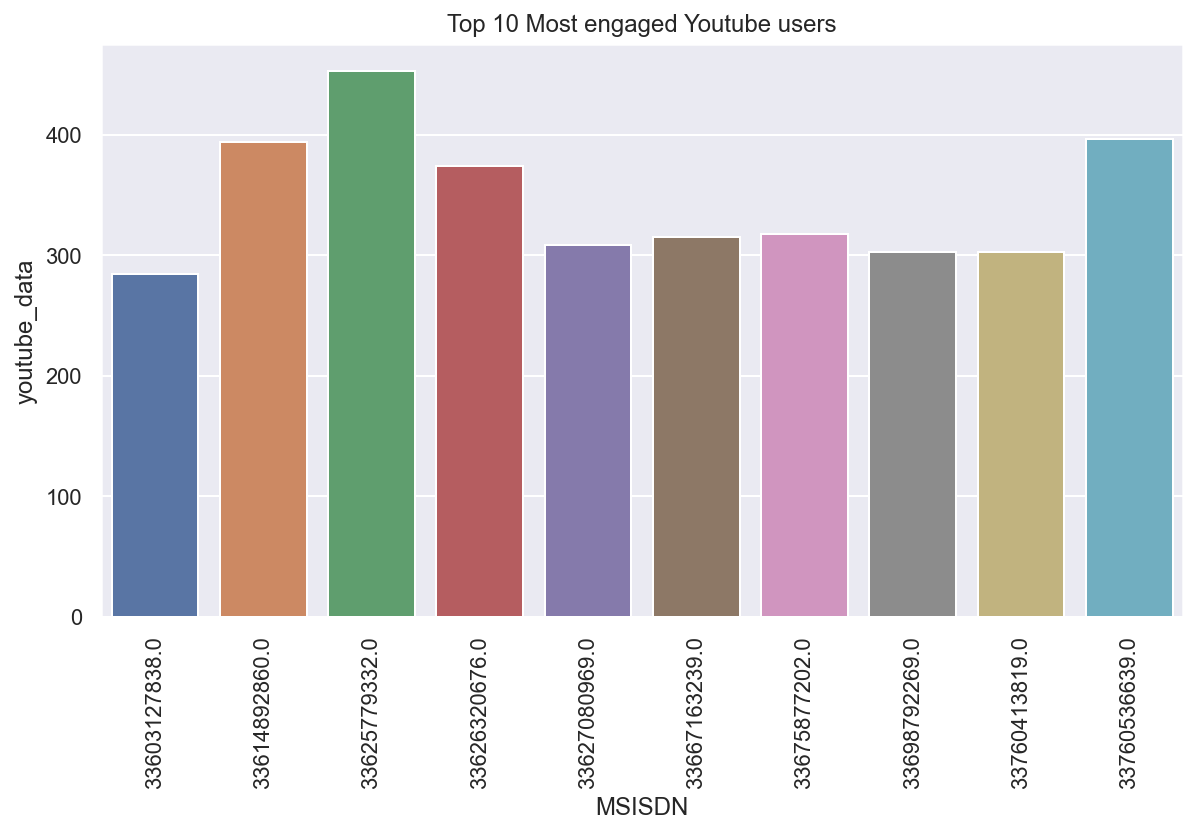

In [127]:
top10_youtube = youtube_volume.sort_values(by='youtube_data', ascending=False)[:10]
sns.barplot(data=top10_youtube, x='MSISDN', y='youtube_data')
plt.title('Top 10 Most engaged Youtube users')
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Top 10 Most engaged Netflix users')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

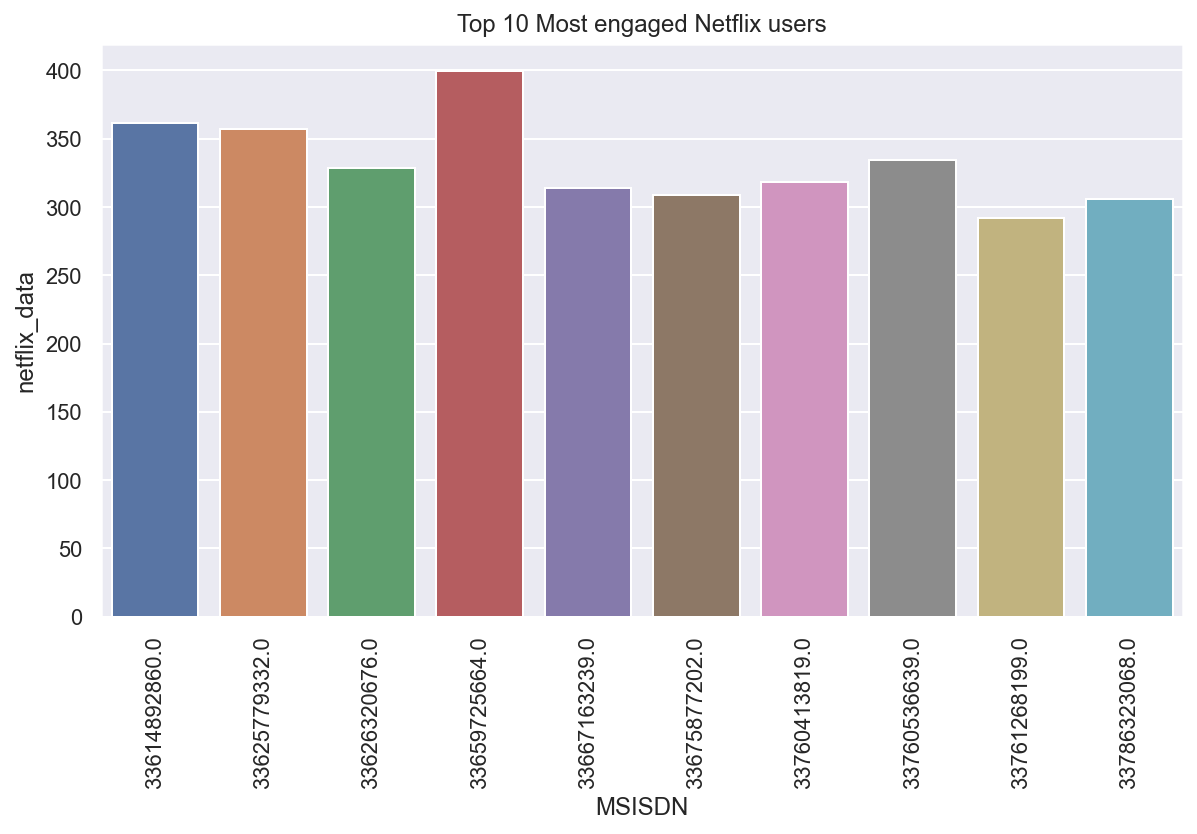

In [128]:
top10_netflix = netflix_volume.sort_values(by='netflix_data', ascending=False)[:10]
sns.barplot(data=top10_netflix, x='MSISDN', y='netflix_data')
plt.title('Top 10 Most engaged Netflix users')
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Top 10 Most engaged Gaming users')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

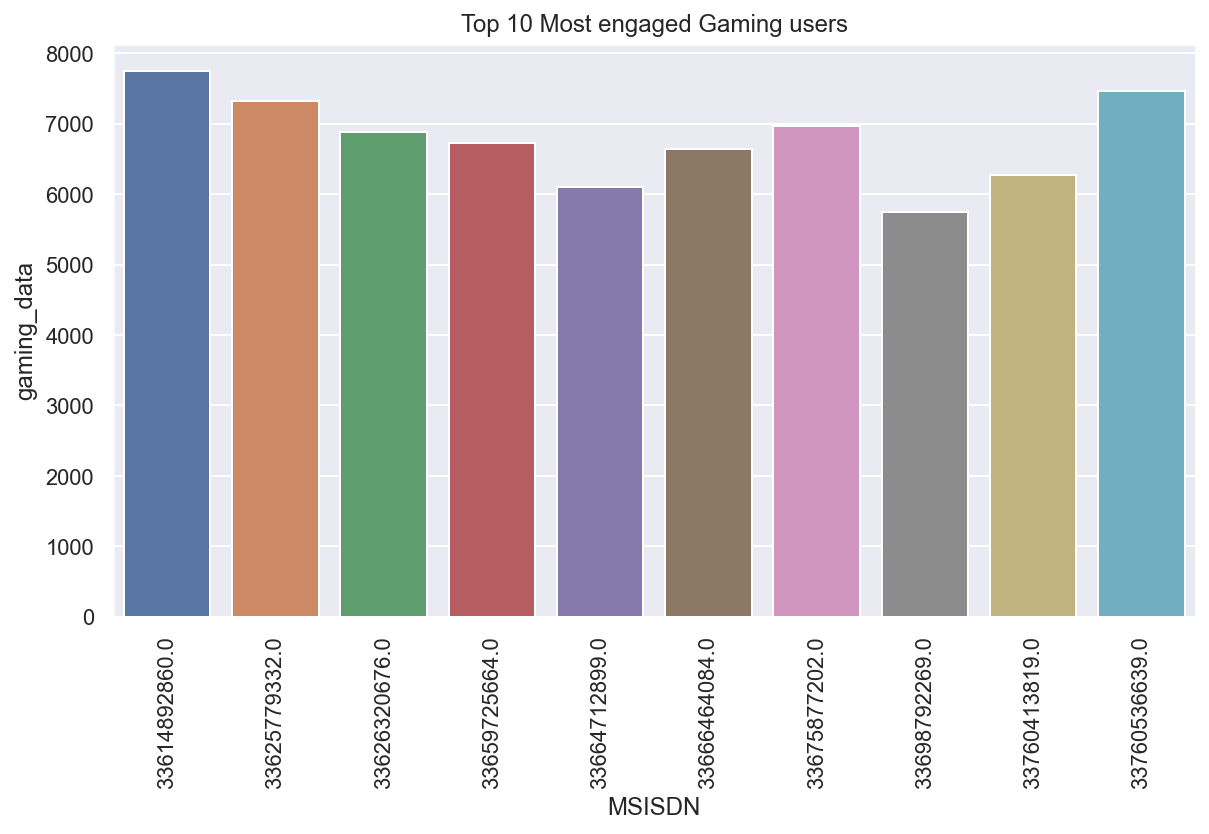

In [130]:
top10_gaming = gaming_volume.sort_values(by='gaming_data', ascending=False)[:10]
sns.barplot(data=top10_gaming, x='MSISDN', y='gaming_data')
plt.title('Top 10 Most engaged Gaming users')
plt.xticks(rotation=90)

In [230]:
most_used_apps = pd.merge(social_volume, email_volume, on='MSISDN')
most_used_apps = pd.merge(most_used_apps, google_volume,on='MSISDN') 
most_used_apps = pd.merge(most_used_apps, youtube_volume, on='MSISDN')
most_used_apps = pd.merge(most_used_apps, netflix_volume, on='MSISDN') 
most_used_apps = pd.merge(most_used_apps, gaming_volume, on='MSISDN')



In [241]:
most_used_apps

,MSISDN,social_data,email_data,google_data,youtube_data,netflix_data,gaming_data
0,3197020876596.0,0.715224,1.520771,10.438660,11.959905,26.592300,178.048738
1,33601001722.0,2.232135,1.331362,4.389005,21.624548,27.180981,812.458661
2,33601001754.0,2.660565,3.307781,5.334863,12.432223,11.221763,119.750078
3,33601002511.0,3.195623,3.205380,3.443126,21.333570,19.353900,538.827713
4,33601007832.0,0.280294,2.284670,9.678493,6.977321,1.942092,391.126127
...,...,...,...,...,...,...,...
106851,33789967113.0,1.413370,3.396607,9.892882,28.226479,30.370302,134.815919
106852,33789980299.0,4.250312,5.315327,10.246473,38.012812,51.950311,972.344996
106853,33789996170.0,0.300183,1.006915,7.531269,26.647843,14.902538,660.361359
106854,33789997247.0,0.498569,2.514097,5.429705,19.851572,8.531060,437.003292


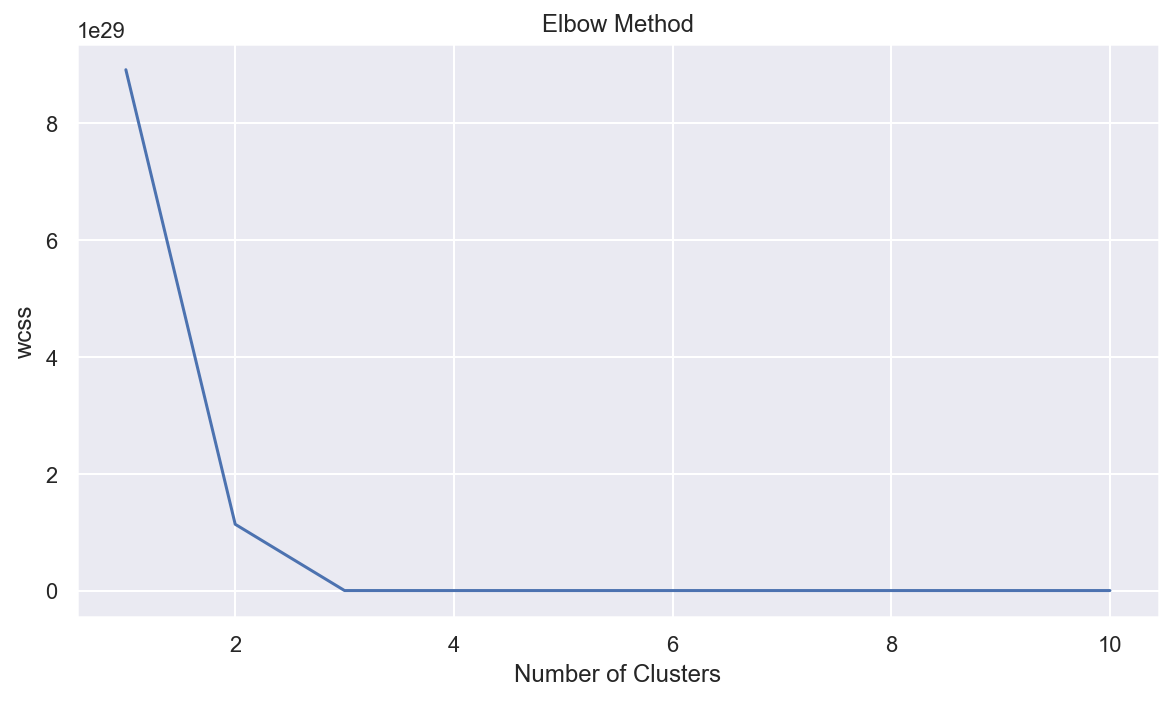

In [210]:
#Use elbow method to determine number of clusters

X = eng_metrics.values
# Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10,random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()


## Task 3


In [252]:
#Already handled missing values and outliers at the top.
data.head()

,Bearer Id,Start,Start ms,End,End ms,IMSI,MSISDN,IMEI,Last Location Name,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),HTTP DL,HTTP UL,Activity Duration DL,Activity Duration UL,Dur,Handset Manufacturer,Handset Type,Nb of sec with 125000B < Vol DL,Nb of sec with 1250B < Vol UL < 6250B,Nb of sec with 31250B < Vol DL < 125000B,Nb of sec with 37500B < Vol UL,Nb of sec with 6250B < Vol DL < 31250B,Nb of sec with 6250B < Vol UL < 37500B,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL,Social Media UL,Google DL,Google UL,Email DL,Email UL,Youtube DL,Youtube UL,Netflix DL,Netflix UL,Gaming DL,Gaming UL,Other DL,Other UL,Total UL,Total DL,Decile_rank,total_bytes,social_media,email,google,youtube,netflix,gaming,other
0,13114483460844900352,2019-04-04 12:01:18,770,2019-04-25 14:35:31,662,208201448079117.0,33664962239.0,35521209507511.0,9164566995485190,42,5,23,44,20884183,766247,100,0,0,0,100,0,0,0,115512385,3269792,37624,38787,1823652892,Samsung,Samsung Galaxy A5 Sm-A520F,994,343,816,150,971,142,213,214,1545765,24420,1634479,1271433,3563542,137762,15854611,2501332,8198936,9656251,278082303,14344150,171744450,8814393,36749741,308879636,4,345629377,1570185,3701304,2905912,18355943,17855187,292426453,180558843
1,13114483482878900224,2019-04-09 13:04:04,235,2019-04-25 08:15:48,606,208201909211140.0,33681854413.0,35794009006359.0,L77566A,65,5,16,26,20884183,766247,100,0,0,0,100,0,0,0,115512385,3269792,168,3560,1365104371,Samsung,Samsung Galaxy J5 (Sm-J530),994,343,816,150,971,142,971,1022,1926113,7165,3493924,920172,629046,308339,20247395,19111729,18338413,17227132,608750074,1170709,526904238,15055145,53800391,653384965,4,707185356,1933278,937385,4414096,39359124,35565545,609920783,541959383
2,13114483484080500736,2019-04-09 17:42:11,1,2019-04-25 11:58:13,652,208200314458056.0,33760627129.0,35281510359387.0,D42335A,108,18,6,9,20884183,766247,100,0,0,0,100,0,0,0,115512385,3269792,0,0,1361762651,Samsung,Samsung Galaxy A8 (2018),994,343,816,150,971,142,751,695,1684053,42224,8535055,1694064,2690151,672973,19725661,14699576,17587794,6163408,229584621,395630,410692588,4215763,27883638,279807335,4,307690973,1726277,3363124,10229119,34425237,23751202,229980251,414908351
3,13114483485442799616,2019-04-10 00:31:25,486,2019-04-25 07:36:35,171,208201402342131.0,33750343200.0,35356610164913.0,T21824A,108,18,44,44,20884183,766247,100,0,0,0,100,0,0,0,115512385,3269792,3330,37882,1321509685,undefined,undefined,994,343,816,150,971,142,17,207,644121,13372,9023734,2788027,1439754,631229,21388122,15146643,13994646,1097942,799538153,10849722,749039933,12797283,43324218,846028530,4,889352748,657493,2070983,11811761,36534765,15092588,810387875,761837216
4,13114483499480700928,2019-04-12 20:10:23,565,2019-04-25 10:40:32,954,208201401415120.0,33699795932.0,35407009745539.0,D88865A,108,18,6,9,20884183,766247,100,0,0,0,100,0,0,0,115512385,3269792,0,0,1089009389,Samsung,Samsung Sm-G390F,994,343,816,150,971,142,607,604,862600,50188,6248284,1500559,1936496,173853,15259380,18962873,17124581,415218,527707248,3529801,550709500,13910322,38542814,569138589,4,607681403,912788,2110349,7748843,34222253,17539799,531237049,564619822


### Averages

In [145]:
avg_tcp = user.agg({'TCP DL Retrans. Vol (Bytes)' : 'sum', 'TCP UL Retrans. Vol (Bytes)': 'sum'}) \
.sum(axis=1).reset_index(name='avg_tcp_data')

In [146]:
avg_rtt = user.agg({'Avg RTT DL (ms)' : 'sum', 'Avg RTT UL (ms)': 'sum'}) \
.sum(axis=1).reset_index(name='avg_rtt_data')

In [147]:
handset_type = user['Handset Type'].value_counts()

In [149]:
avg_tput = user.agg({'Avg Bearer TP DL (kbps)' : 'sum', 'Avg Bearer TP UL (kbps)': 'sum'}) \
.sum(axis=1).reset_index(name='avg_tput_data')

### Top10

In [293]:
top10_tcp = avg_tcp.sort_values(by='avg_tcp_data', ascending=False).head(10)
top10_tcp

In [ ]:
top10_rtt = avg_rtt.sort_values(by='avg_rtt_data', ascending=False).head(10)
top10_rtt

In [ ]:
top10_tput = avg_tput.sort_values(by='avg_tput_data', ascending=False).head(10)
top10_tput

### Bottom10

In [ ]:
bottom10_tcp = avg_tcp.sort_values(by='avg_tcp_data', ascending=False).tail(10)
bottom10_tcp

In [ ]:
bottom10_rtt = avg_rtt.sort_values(by='avg_rtt_data', ascending=False).tail(10)
bottom10_tcp

In [ ]:
bottom10_tput =  avg_tput.sort_values(by='avg_tput_data', ascending=False).tail(10)
bottom10_tput

### Frequencies

In [303]:
freq_tcp = avg_tcp['avg_tcp_data'].value_counts().max()
freq_tcp

In [ ]:
freq_rtt = avg_rtt['avg_rtt_data'].value_counts().max()
freq_rtt

In [ ]:
freq_tput = avg_tput['avg_tput_data'].value_counts().max()

In [211]:
exp_metrics = pd.merge(avg_tcp, avg_rtt, on='MSISDN').merge(avg_tput, on='MSISDN')


In [212]:
exp_metrics

,MSISDN,avg_tcp_data,avg_rtt_data,avg_tput_data
0,3197020876596.0,2.165043e+07,125.861976,1.0
1,33601001722.0,2.165043e+07,46.000000,76.0
2,33601001754.0,2.165043e+07,31.000000,99.0
3,33601002511.0,2.165043e+07,125.861976,97.0
4,33601007832.0,7.673135e+05,84.000000,248.0
...,...,...,...,...
106851,33789967113.0,2.165043e+07,53.000000,67.0
106852,33789980299.0,2.166053e+07,194.861976,163079.0
106853,33789996170.0,2.180450e+05,52.000000,10365.0
106854,33789997247.0,2.165043e+07,40.000000,116.0


In [213]:
norm_exp_metrics = StandardScaler().fit_transform(exp_metrics.drop('MSISDN', axis=1))

In [214]:
kmeans2 = KMeans(init='k-means++',n_clusters=3, n_init=10)
results  = kmeans2.fit(norm_exp_metrics)
centers = kmeans2.cluster_centers_
exp_metrics['Clusters'] = kmeans2.labels_
print(centers)



[[-0.05857448 -0.03977405 -0.26789563]
 [19.06977552  0.28844854  3.03245597]
 [ 0.11191667  0.33911084  2.2614151 ]]


In [215]:
exp_metrics[exp_metrics['Clusters']==0].describe()

,avg_tcp_data,avg_rtt_data,avg_tput_data,Clusters
count,9.565100e+04,95651.000000,95651.000000,95651.0
mean,2.118815e+07,148.763076,9642.738215,0.0
std,2.607820e+07,323.342474,16437.794575,0.0
min,9.700000e+01,0.000000,0.000000,0.0
25%,9.937025e+06,45.000000,94.000000,0.0
50%,2.165043e+07,87.000000,175.000000,0.0
75%,2.165043e+07,125.861976,13367.500000,0.0
max,1.377064e+09,6954.000000,66174.000000,0.0


In [216]:
exp_metrics[exp_metrics['Clusters']==1].describe()

,avg_tcp_data,avg_rtt_data,avg_tput_data,Clusters
count,2.290000e+02,229.000000,229.000000,229.0
mean,2.955071e+09,368.706969,149671.834061,1.0
std,1.143365e+09,394.982321,103753.475764,0.0
min,1.488287e+09,52.000000,8876.000000,1.0
25%,1.997260e+09,131.000000,68328.000000,1.0
50%,2.775279e+09,248.000000,118209.000000,1.0
75%,3.590128e+09,452.000000,203278.000000,1.0
max,8.354209e+09,2860.000000,549661.000000,1.0


In [217]:
exp_metrics[exp_metrics['Clusters']==2].describe()

,avg_tcp_data,avg_rtt_data,avg_tput_data,Clusters
count,1.097600e+04,10976.000000,10976.000000,10976.0
mean,4.747886e+07,403.742937,117155.213192,2.0
std,1.282671e+08,1843.379864,65104.185813,0.0
min,1.080000e+03,21.000000,3.000000,2.0
25%,3.636651e+06,83.000000,76426.500000,2.0
50%,2.177200e+07,164.000000,95652.500000,2.0
75%,4.017073e+07,336.000000,134913.750000,2.0
max,1.501541e+09,96924.000000,902222.000000,2.0


### Task 4


In [218]:
eng_cluster_low = kmeans.cluster_centers_[0]
exp_cluster_low = kmeans2.cluster_centers_[0]


In [224]:
eng_score = [np.linalg.norm(row - eng_cluster_low) for row in eng_metrics.drop('MSISDN',axis=1).to_numpy()]
eng_metrics['eng_score'] = eng_score

exp_score = [np.linalg.norm(row - exp_cluster_low) for row in exp_metrics.drop('MSISDN',axis=1).to_numpy()]
exp_metrics['exp_score'] = exp_score


ValueError: operands could not be broadcast together with shapes (4,) (3,) 

In [ ]:
satisfaction_data = pd.merge()

In [226]:
eng_metrics

,MSISDN,session_frequency,session_duration_mins,session_traffic_MB,Cluster
0,3197020876596.0,1,14.623118,232.123971,1
1,33601001722.0,1,1.945340,878.690574,1
2,33601001754.0,1,3.020522,156.859643,1
3,33601002511.0,1,2.249494,595.966483,1
4,33601007832.0,1,0.831302,422.320698,1
...,...,...,...,...,...
106851,33789967113.0,1,2.674365,208.123067,1
106852,33789980299.0,2,3.506509,1094.693386,0
106853,33789996170.0,1,0.146845,714.641641,1
106854,33789997247.0,1,2.349816,480.307335,1


In [203]:
eng_metrics

,MSISDN,session_frequency,session_duration_mins,session_traffic_MB
0,3197020876596.0,1,14.623118,232.123971
1,33601001722.0,1,1.945340,878.690574
2,33601001754.0,1,3.020522,156.859643
3,33601002511.0,1,2.249494,595.966483
4,33601007832.0,1,0.831302,422.320698
...,...,...,...,...
106851,33789967113.0,1,2.674365,208.123067
106852,33789980299.0,2,3.506509,1094.693386
106853,33789996170.0,1,0.146845,714.641641
106854,33789997247.0,1,2.349816,480.307335
